<a href="https://colab.research.google.com/github/xhavien/CCADMACL_EXERCISES_COM222-ML/blob/main/Exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise 2: Use Gradient Boost for Regression

Instructions:

- Use the Dataset File to train your model
- Use the Test File to generate your results
- Use the Sample Submission file to generate the same format
Submit your results to:
https://www.kaggle.com/competitions/playground-series-s4e12/overview



In [ ]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

## Dataset
Train, test and sample submission file can be found in this link
https://www.kaggle.com/competitions/playground-series-s4e12/data

## 1. Load the Data

In [ ]:
!pip install --user xgboost

In [ ]:

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import root_mean_squared_log_error

warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd

# Load the training dataset
train_df = pd.read_csv('train.csv')

# Load the testing dataset
test_df = pd.read_csv('test.csv')



In [ ]:
train_df.head()


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

## 2. Perform Data preprocessing

In [ ]:
import pandas as pd
# Strip any leading/trailing spaces from column names
train_df.columns = train_df.columns.str.strip()

# Drop the 'Policy Start Date' column
# Drop both 'id' and 'Policy Start Date' columns
train_df = train_df.drop(['id','Policy Start Date'], axis=1)


# Columns that need encoding (non-numeric)
categorical_columns = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
                       'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
                       'Property Type']

# Convert numerical columns to float
numeric_columns = train_df.columns.difference(categorical_columns)
train_df[numeric_columns] = train_df[numeric_columns].astype(float)

# For categorical columns, apply encoding
for col in categorical_columns:
    train_df[col] = train_df[col].astype('category').cat.codes.astype(int)

# Now, all columns in train_df are in float format except 'Policy Start Date' which has been dropped

In [ ]:
import pandas as pd

# Strip any leading/trailing spaces from column names for test_df
test_df.columns = test_df.columns.str.strip()

# Drop the 'id' and 'Policy Start Date' columns from test_df (similar to train_df)
test_df = test_df.drop(['Policy Start Date'], axis=1)

# Columns that need encoding (non-numeric)
categorical_columns = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
                       'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
                       'Property Type']

# Convert numerical columns to float in test_df
numeric_columns = test_df.columns.difference(categorical_columns)
test_df[numeric_columns] = test_df[numeric_columns].astype(float)

# For categorical columns, apply encoding to test_df
for col in categorical_columns:
    test_df[col] = test_df[col].astype('category').cat.codes.astype(int)

# Now test_df has the same preprocessing as train_df


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Extract features and target
X = train_df.drop(columns=['Premium Amount'])  # Features (all columns except 'Premium Amount')
y = train_df['Premium Amount']  # Target variable ('Premium Amount')

# Handle missing values in the target variable (y)
y_imputer = SimpleImputer(strategy='mean')  # Use mean imputation for missing target values
y_imputed = y_imputer.fit_transform(y.values.reshape(-1, 1)).ravel()  # Impute NaNs in target

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y_imputed, test_size=0.2, random_state=42)

# Create DMatrix for XGBoost
dtrain_reg = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)  # Training data
dtest_reg = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)  # Testing data


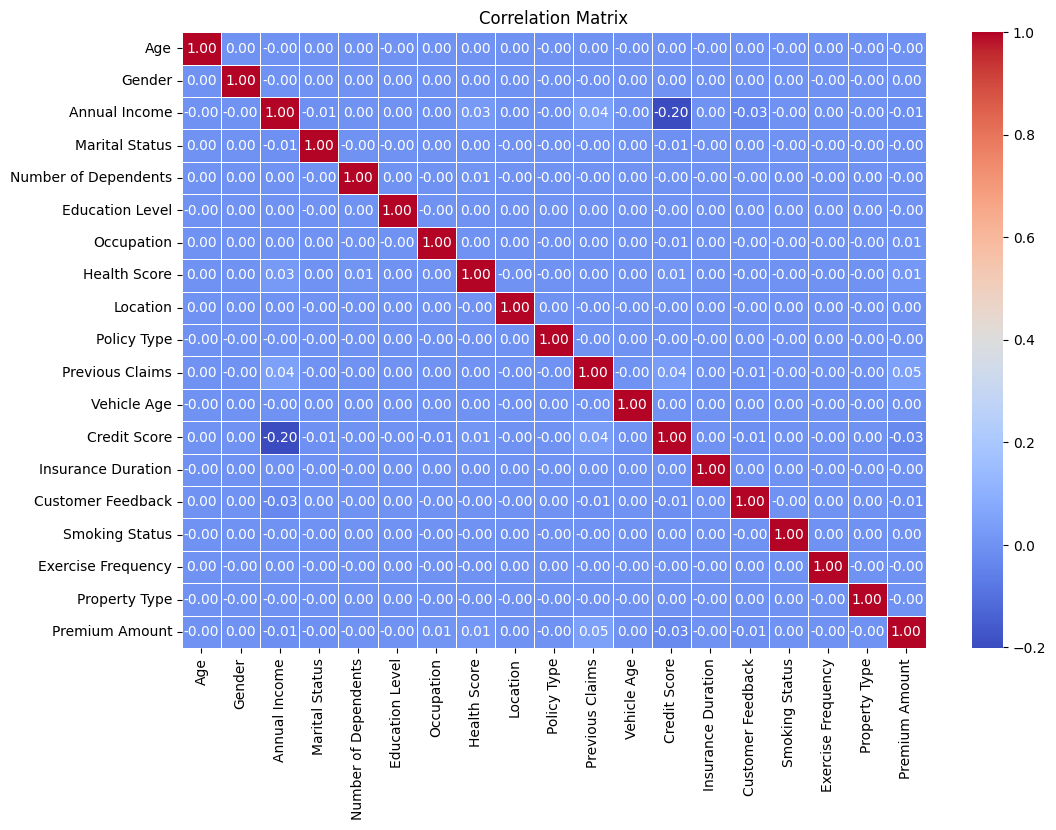

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_df' is the DataFrame with numeric columns (after encoding)

# 1. Compute the correlation matrix
correlation_matrix = train_df.corr()

# 2. Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# 3. Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# 4. Display the plot
plt.title("Correlation Matrix")
plt.show()


In [ ]:
train_df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,19.0,0,10049.0,1,1.0,0,1,22.598761,2,2,2.0,17.0,372.0,5.0,2,0,3,2,2869.0
1,39.0,0,31678.0,0,3.0,2,-1,15.569731,0,1,1.0,12.0,694.0,2.0,0,1,1,2,1483.0
2,23.0,1,25602.0,0,3.0,1,1,47.177549,1,2,1.0,14.0,NaN,3.0,1,1,3,2,567.0
3,21.0,1,141855.0,1,2.0,0,-1,10.938144,0,0,1.0,0.0,367.0,1.0,2,1,0,0,765.0
4,21.0,1,39651.0,2,1.0,0,1,20.376094,0,2,0.0,8.0,598.0,4.0,2,1,3,2,2022.0


## 3. Create a Pipeline

In [ ]:
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

In [ ]:
from sklearn.pipeline import Pipeline  # Import Pipeline
from xgboost import XGBRegressor  # Import XGBRegressor

# Define the pipeline
pipeline = Pipeline([
    ('model', XGBRegressor(**params))  # Initialize the model with parameters
])


## 4. Train the Model

In [ ]:
n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

In [ ]:
preds = model.predict(dtest_reg)

## 5. Evaluate the Model

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_log_error

# Check for zero or negative values in y_test and preds
if (y_test <= 0).any() or (preds <= 0).any():
    print("Warning: Zero or negative values found in the data.")

    # Optionally, add a small constant to handle zero or negative values
    y_test = np.maximum(y_test, 1e-5)  # Replace values <= 0 with a small constant
    preds = np.maximum(preds, 1e-5)  # Same for predictions

# Log-transform the target variable and predictions
y_test_transformed = np.log1p(y_test)  # log1p handles zero values
preds_transformed = np.log1p(preds)

# Compute RMSLE
rmse = mean_squared_log_error(y_test_transformed, preds_transformed)
print(f"RMSLE: {rmse:.3f}")


RMSLE: 0.030


In [ ]:
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 100

In [ ]:

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
)


[0]	train-rmse:854.03811	validation-rmse:853.52504
[1]	train-rmse:848.48299	validation-rmse:848.09438
[2]	train-rmse:845.92923	validation-rmse:845.61602
[3]	train-rmse:844.43040	validation-rmse:844.21318
[4]	train-rmse:843.41566	validation-rmse:843.30350
[5]	train-rmse:842.46304	validation-rmse:842.46125
[6]	train-rmse:842.11351	validation-rmse:842.24742
[7]	train-rmse:841.55716	validation-rmse:841.79912
[8]	train-rmse:840.99107	validation-rmse:841.34697
[9]	train-rmse:840.81104	validation-rmse:841.31491
[10]	train-rmse:840.53427	validation-rmse:841.15881
[11]	train-rmse:840.26230	validation-rmse:841.03918
[12]	train-rmse:840.07148	validation-rmse:840.95216
[13]	train-rmse:839.82715	validation-rmse:840.81180
[14]	train-rmse:839.72902	validation-rmse:840.80693
[15]	train-rmse:839.61698	validation-rmse:840.81713
[16]	train-rmse:839.42680	validation-rmse:840.73224
[17]	train-rmse:839.30021	validation-rmse:840.73282
[18]	train-rmse:839.13379	validation-rmse:840.65838
[19]	train-rmse:839.00

In [ ]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  int64  
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1200000 non-null  int64  
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  int64  
 6   Occupation            1200000 non-null  int64  
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  int64  
 9   Policy Type           1200000 non-null  int64  
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Customer Feedback     1200000 non-

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    800000 non-null  float64
 1   Age                   787511 non-null  float64
 2   Gender                800000 non-null  int64  
 3   Annual Income         770140 non-null  float64
 4   Marital Status        800000 non-null  int64  
 5   Number of Dependents  726870 non-null  float64
 6   Education Level       800000 non-null  int64  
 7   Occupation            800000 non-null  int64  
 8   Health Score          750551 non-null  float64
 9   Location              800000 non-null  int64  
 10  Policy Type           800000 non-null  int64  
 11  Previous Claims       557198 non-null  float64
 12  Vehicle Age           799997 non-null  float64
 13  Credit Score          708549 non-null  float64
 14  Insurance Duration    799998 non-null  float64
 15  

## Generate Submission File

Choose the model that has the best performance to generate a submission file.

In [ ]:
# Ensure the test_df is copied correctly
sf = test_df.copy()  # If test_df is your dataset, copy it to 'sf'

# Convert all columns to Int32, if possible
sf = sf.apply(pd.to_numeric, errors='coerce', downcast='integer')

# Check the data types of the columns
print(sf.dtypes)  # Ensure all columns are now of type Int32 or compatible

# Fit the pipeline to your training data
pipeline.fit(X_train, y_train)  # Ensure that X_train and y_train are defined

# Pop the 'id' column to get the id values
id = sf.pop('id')  # Pop the 'id' column for the submission

# Make predictions (excluding the 'id' column)
y_pred = pipeline.predict(sf)  # Use the rest of the data (sf) for prediction

# Create a submission DataFrame
submission_df = pd.DataFrame({
    'id': id,  # Add the 'id' column
    'Premium Amount': y_pred  # Add the predictions
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission_file.csv', index=False)

# Print confirmation message
print("Submission file created: submission_file.csv")


id                        int32
Age                     float64
Gender                     int8
Annual Income           float64
Marital Status             int8
Number of Dependents    float64
Education Level            int8
Occupation                 int8
Health Score            float64
Location                   int8
Policy Type                int8
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Customer Feedback          int8
Smoking Status             int8
Exercise Frequency         int8
Property Type              int8
dtype: object
Submission file created: submission_file.csv
